> Para cada tipo de pago y segmento de cliente, devolver la suma y el promedio expresado como porcentaje, de clientes activos y de consentimiento de marketing. Se valora que el output de la consulta tenga nombres claros y en español.

Para esta consulta vamos a necesitar los datasets de `orders` y `customers`.

El primer paso sería realizar un `merge` entre ambos datasets, utilizando la columna `customer_id` que es común a ambos. Particularmente vamos a hacer un inner join, ya que nos interesan solamente los pedidos que tengan un cliente conocido asociado para poder conocer su segmento, su consentimiento y su estado de actividad.

In [2]:
import pandas as pd

df_customers = pd.read_pickle("../../.data/clean/customers.pkl")
df_orders = pd.read_pickle("../../.data/clean/orders.pkl")

In [3]:
df_orders = df_orders[["customer_id", "payment_method"]]
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4700000 entries, 1 to 4700000
Data columns (total 2 columns):
 #   Column          Dtype   
---  ------          -----   
 0   customer_id     Int64   
 1   payment_method  category
dtypes: Int64(1), category(1)
memory usage: 80.7+ MB


In [4]:
df_customers = df_customers[["customer_segment", "marketing_consent", "is_active"]]
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 1 to 500000
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_segment   454954 non-null  string 
 1   marketing_consent  500000 non-null  boolean
 2   is_active          500000 non-null  boolean
dtypes: boolean(2), string(1)
memory usage: 9.5 MB


In [5]:
merged_orders = pd.merge(
    df_orders, df_customers, left_on="customer_id", right_index=True, how="inner"
)

merged_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4700000 entries, 1 to 4700000
Data columns (total 5 columns):
 #   Column             Dtype   
---  ------             -----   
 0   customer_id        Int64   
 1   payment_method     category
 2   customer_segment   string  
 3   marketing_consent  boolean 
 4   is_active          boolean 
dtypes: Int64(1), boolean(2), category(1), string(1)
memory usage: 134.5+ MB


Antes de pasar a realizar los agrupamientos, vamos a eliminar los registros que representen al mismo cliente con el mismo método de pago ya que en ese caso estaríamos contando varias ordenes del mismo cliente en las mismas condiciones y eso no sería del todo representativo.

In [6]:
merged_orders.drop_duplicates(subset=["customer_id", "payment_method"], inplace=True)
merged_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 697975 entries, 1 to 4699879
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   customer_id        697975 non-null  Int64   
 1   payment_method     599485 non-null  category
 2   customer_segment   634049 non-null  string  
 3   marketing_consent  697975 non-null  boolean 
 4   is_active          697975 non-null  boolean 
dtypes: Int64(1), boolean(2), category(1), string(1)
memory usage: 20.0+ MB


Como vemos esto no es una simple validación rebuscada, es una validación que baja la cantidad de registros de 4.7M a aproxidamente 700k registros únicos. Esto resulta en un rebaje de casi un orden de magnitud, lo cual es significativo y nos indica que muchos clientes han realizado múltiples órdenes con el mismo método de pago. 

Ahora vamos a realizar los distintos agrupamientos para poder responder las disntas consultas.

Los grupos serán formados como una combinación de las columnas `payment_method`, `customer_segment`.

Luego para cada grupo vamos a calcular:

- La cantidad total de clientes en el grupo
- La cantidad de clientes activos
- La cantidad de clientes con consentimiento de marketing

Cabe aclarar que en la limpieza de datos se validó si las columnas booleanas tenían valores distintos a True, False y en este caso NO se encontraron valores inválidos, por lo que podemos asumir que todos los valores están en los formatos correctos.

Luego una vez tengamos esa información, podemos hacer las operaciones necesarias para obtener los porcentajes pero ahora operando sobre los totales de cada grupo y no sobre los registros individuales.

In [7]:
statistics_by_payment_and_segment = merged_orders.groupby(
    ["payment_method", "customer_segment"], dropna=False, observed=True
).agg(
    total_clients=("customer_id", "count"),
    active_clients=("is_active", "sum"),
    consented_clients=("marketing_consent", "sum"),
)

statistics_by_payment_and_segment

total_clients  active_clients  \
payment_method   customer_segment                                  
BANK TRANSFER    Budget                    17867           16041   
                 Premium                   18292           16441   
                 Regular                   54606           49126   
                 <NA>                       9149            8233   
CASH ON DELIVERY Budget                    17863           16040   
                 Premium                   18288           16437   
                 Regular                   54620           49140   
                 <NA>                       9151            8233   
CREDIT CARD      Budget                    17865           16039   
                 Premium                   18286           16434   
                 Regular                   54614           49132   
                 <NA>                       9149            8232   
DEBIT CARD       Budget                    17860           16034   
                 Premium                   18292           16442   
                 Regular                   54606           49130   
                 <NA>                       9150            8234   
DIGITAL WALLET   Budget                    17863           16039   
                 Premium                   18290           16440   
                 Regular                   54606           49127   
                 <NA>                       9149            8231   
PAYPAL           Budget                    17863           16039   
                 Premium                   18286           16435   
                 Regular                   54620           49138   
                 <NA>                       9150            8233   
<NA>             Budget                    17598           15806   
                 Premium                   18004           16172   
                 Regular                   53860           48441   
                 <NA>                       9028            8123   

                                   consented_clients  
payment_method   customer_segment                     
BANK TRANSFER    Budget                        12451  
                 Premium                       12808  
                 Regular                       38297  
                 <NA>                           6368  
CASH ON DELIVERY Budget                        12449  
                 Premium                       12807  
                 Regular                       38307  
                 <NA>                           6368  
CREDIT CARD      Budget                        12448  
                 Premium                       12807  
                 Regular                       38301  
                 <NA>                           6367  
DEBIT CARD       Budget                        12441  
                 Premium                       12810  
                 Regular                       38295  
                 <NA>                           6369  
DIGITAL WALLET   Budget                        12445  
                 Premium                       12808  
                 Regular                       38299  
                 <NA>                           6365  
PAYPAL           Budget                        12446  
                 Premium                       12808  
                 Regular                       38306  
                 <NA>                           6367  
<NA>             Budget                        12263  
                 Premium                       12606  
                 Regular                       37783  
                 <NA>                           6287

In [8]:
statistics_by_payment_and_segment["percentaje_active_clients"] = (
    statistics_by_payment_and_segment["active_clients"]
    / statistics_by_payment_and_segment["total_clients"]
    * 100
).round(2)
statistics_by_payment_and_segment["percentaje_consented_clients"] = (
    statistics_by_payment_and_segment["consented_clients"]
    / statistics_by_payment_and_segment["total_clients"]
    * 100
).round(2)

statistics_by_payment_and_segment.describe()

,total_clients,active_clients,consented_clients,percentaje_active_clients,percentaje_consented_clients
count,28.0,28.0,28.0,28.0,28.0
mean,24927.678571,22414.0,17445.571429,89.901071,69.859643
std,17780.572467,16000.257542,12492.068543,0.078615,0.231844
min,9028.0,8123.0,6287.0,89.78,69.57
25%,15486.25,13913.0,10789.5,89.82,69.655
50%,17935.5,16106.5,12528.5,89.915,69.855
75%,27184.0,24441.75,19053.25,89.97,70.0625
max,54620.0,49140.0,38307.0,89.99,70.15


De esta última tabla podemos sacar información relevante, lo primero que salta a la vista es que si bien la cantidad de clientes por grupo (método de pago y segmento) es bastante disperso (de 9k a 54k clientes, medio orden de magnitud). Esta misma tendencia se ve reflejada en la cantidad de clientes activos y con consentimiento de marketing en terminos absolutos sin embargo cuando vemos los porcentajes, la dispersión es muy pequeña. Todos los grupos tienen 89% aproximadamente de porcentaje de clientes activos y 69%-70% aproximadamente de porcentaje de clientes con consentimiento de marketing.

Podemos visualizar esta misma información con una serie de mapas de calor, clasificando por segmento de cliente y por método de pago utilizado y observando las tendencias de cada una de las estadísticas.

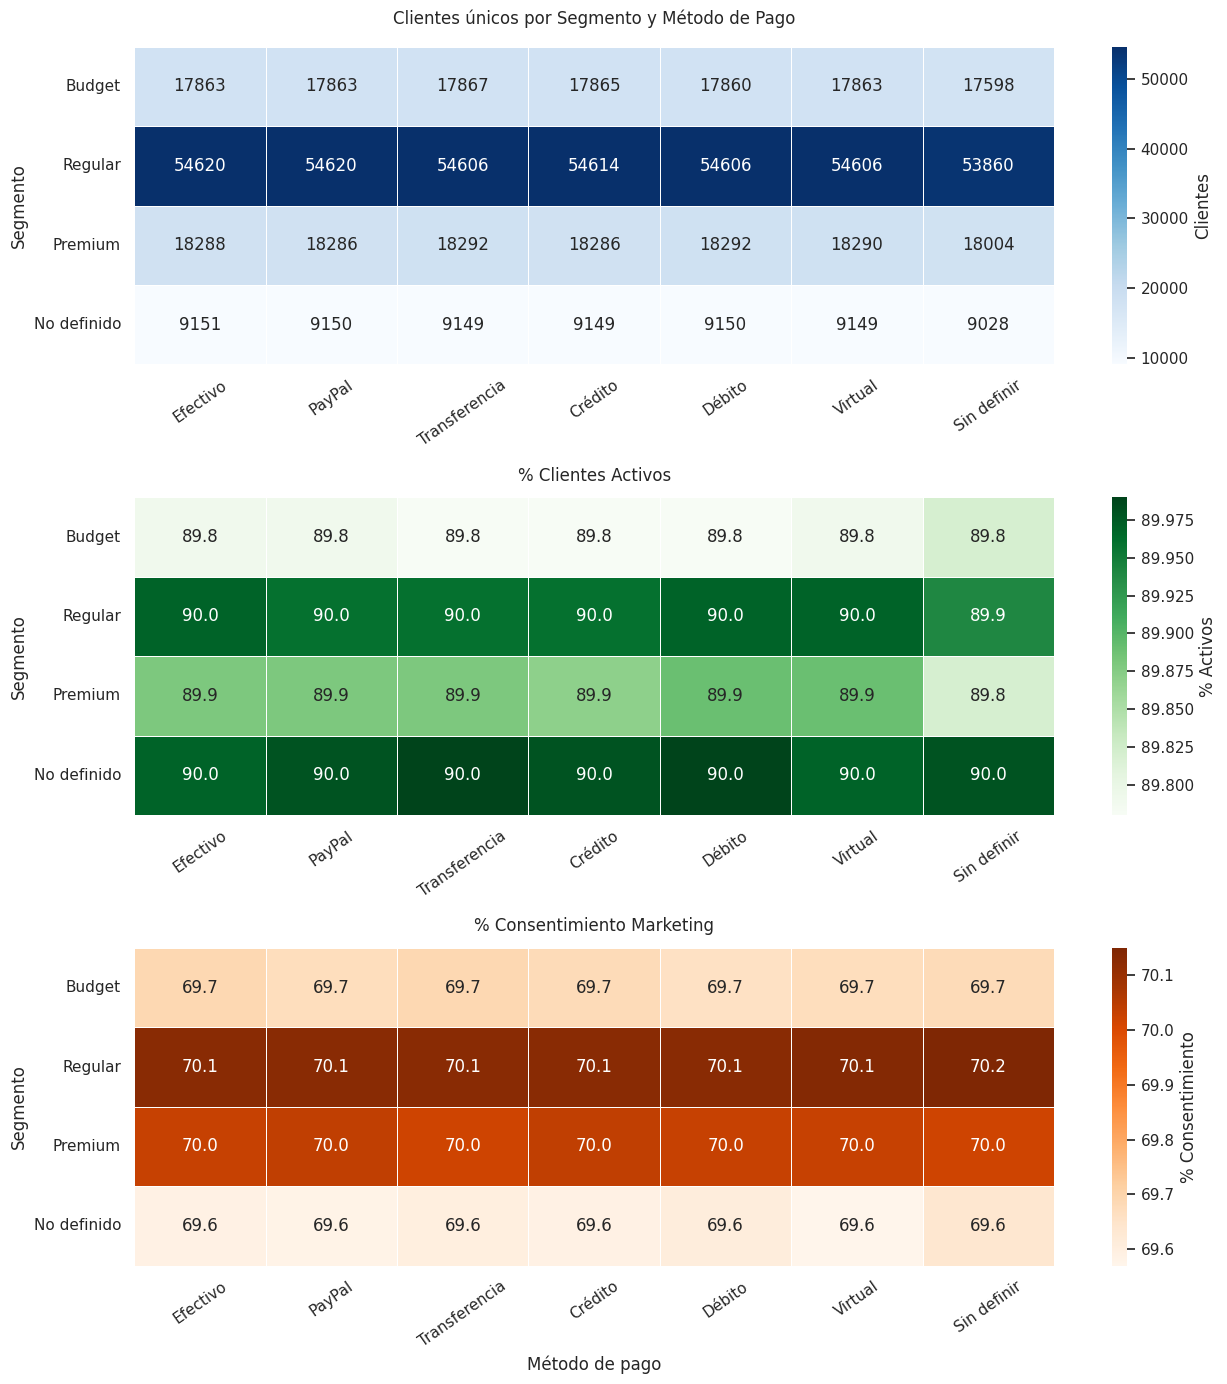

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

payment_map = {
    'CREDIT CARD': 'Crédito',
    'DEBIT CARD': 'Débito',
    'PAYPAL': 'PayPal',
    'BANK TRANSFER': 'Transferencia',
    'DIGITAL WALLET': 'Virtual',
    'CASH ON DELIVERY': 'Efectivo'
}

stats = statistics_by_payment_and_segment.copy()
active_col = 'percentaje_active_clients'
consent_col = 'percentaje_consented_clients'
if active_col not in stats.columns:
    ac = [c for c in stats.columns if 'active' in c.lower() and '%' in c.lower()]
    active_col = ac[0]
if consent_col not in stats.columns:
    cc = [c for c in stats.columns if 'consent' in c.lower() and '%' in c.lower()]
    consent_col = cc[0]

def build_pivot(series):
    p = series.unstack('payment_method')
    cols = []
    for col in p.columns:
        if pd.isna(col):
            cols.append('Sin definir')
        else:
            cols.append(payment_map.get(col, col))
    p.columns = cols
    p.index = p.index.to_series().fillna('No definido')
    return p

pivot_total = build_pivot(stats['total_clients']).fillna(0).astype(int)
pivot_active = build_pivot(stats[active_col]).apply(pd.to_numeric, errors='coerce').astype(float)
pivot_consent = build_pivot(stats[consent_col]).apply(pd.to_numeric, errors='coerce').astype(float)

row_order = ['Budget', 'Regular', 'Premium', 'No definido']
existing_rows = [r for r in row_order if r in pivot_total.index]
remaining_rows = [r for r in pivot_total.index if r not in row_order]
for ref in [pivot_total, pivot_active, pivot_consent]:
    ref = ref.reindex(existing_rows + remaining_rows)

pivot_total = pivot_total.reindex(existing_rows + remaining_rows)
pivot_active = pivot_active.reindex(pivot_total.index)
pivot_consent = pivot_consent.reindex(pivot_total.index)

col_order = pivot_total.sum(axis=0).sort_values(ascending=False).index.tolist()
for p in [pivot_active, pivot_consent]:
    extra = [c for c in p.columns if c not in col_order]
    if extra:
        col_order_ext = col_order + extra
        pivot_total = pivot_total.reindex(columns=col_order_ext)
        pivot_active = pivot_active.reindex(columns=col_order_ext)
        pivot_consent = pivot_consent.reindex(columns=col_order_ext)
        col_order = col_order_ext
pivot_total = pivot_total[col_order]
pivot_active = pivot_active[col_order]
pivot_consent = pivot_consent[col_order]

pivot_active = pivot_active.fillna(0)
pivot_consent = pivot_consent.fillna(0)

sns.set_theme(style='white')
fig, axes = plt.subplots(3, 1, figsize=(1.3 * len(col_order) + 4, 14))

sns.heatmap(pivot_total, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={'label': 'Clientes'}, ax=axes[0])
axes[0].set_title('Clientes únicos por Segmento y Método de Pago', pad=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('Segmento')

sns.heatmap(pivot_active, annot=True, fmt='.1f', cmap='Greens', linewidths=.5, cbar_kws={'label': '% Activos'}, ax=axes[1])
axes[1].set_title('% Clientes Activos', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('Segmento')

sns.heatmap(pivot_consent, annot=True, fmt='.1f', cmap='Oranges', linewidths=.5, cbar_kws={'label': '% Consentimiento'}, ax=axes[2])
axes[2].set_title('% Consentimiento Marketing', pad=12)
axes[2].set_xlabel('Método de pago')
axes[2].set_ylabel('Segmento')

for ax in axes:
    ax.tick_params(axis='x', rotation=35)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

Se puede observar muy rapidamente que en la cantidad de clientes por segmento varía muchísimo, no así por método de pago.

Los otros 2 gráficos también muestran una cierta tendencia de estabilidad a lo largo de los segmenteos de cliente pero ahí no nos debemos dejar engañar por los colores y debemos observar los rangos sobre los cuales operan estos colores. Como vemos estos son muy pequeños y no resultan significativos para sacar ninguna conclusión respecto a la actividad o el consentimiento de ningun segmento de clientes en particular, ni de ningún comportamiento diferente en función del método de pago.